# Terminal-value simulation

Let's find the fastest solver for a non-stiff, low-dimensional test problem.

In [3]:
from functools import partial

import jax
import jax.experimental.ode
import jax.numpy as jnp
import matplotlib.pyplot as plt
from _benchmark_utils import most_recent_commit, plot_config, time
from diffeqzoo import backend, ivps
from jax import config
from tqdm import tqdm

from odefilter import controls, ivpsolve, recipes

# Nice-looking plots
plt.rcParams.update(plot_config())

# x64 precision
config.update("jax_enable_x64", True)

# IVP examples in JAX, not in NumPy
backend.select("jax")

In [4]:
from odefilter import __version__ as odefilter_version  # noqa: E402

commit = most_recent_commit(abbrev=6)


print(f"Most recent commit:\n\t{commit}")
print(f"odefilter version:\n\t{odefilter_version}")

Most recent commit:
	b'ecbfd3\n'
odefilter version:
	0.1.dev81


In [5]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.three_body_restricted_first_order()


@jax.jit
def vf(x, *, t, p):
    return f(x, *p)


# Compile
vf(u0, t=t0, p=f_args)

ts = jnp.asarray([t0, t1])
odeint_solution = jax.experimental.ode.odeint(
    lambda u, t, *p: vf(u, t=t, p=p), u0, ts, *f_args, atol=1e-12, rtol=1e-12
)
ys_reference = odeint_solution[-1, :]

## Internal solvers

In [6]:
@partial(jax.jit, static_argnames=("num_derivatives", "factory"))
def benchmark(*, num_derivatives, atol, rtol, factory):
    ekf0, info_op = factory(num_derivatives=num_derivatives)
    return solve(solver=ekf0, info_op=info_op, atol=atol, rtol=rtol)


def solve(*, solver, info_op, atol, rtol):
    # Terminal-value simulation likes clipped controls
    controller = controls.ClippedProportionalIntegral()
    solution = ivpsolve.simulate_terminal_values(
        vf,
        initial_values=(u0,),
        t0=t0,
        t1=t1,
        parameters=f_args,
        solver=solver,
        info_op=info_op,
        atol=atol,
        rtol=rtol,
        control=controller,
    )
    return jnp.linalg.norm(solution.u - ys_reference) / jnp.sqrt(u0.size)

In [9]:
tolerances = 0.1 ** jnp.arange(2.0, 12.0, step=1.0)


def ekf1_factory(n):
    return recipes.dynamic_ekf1(num_derivatives=n, ode_dimension=u0.shape[0])


factories = [
    (lambda **kw: recipes.dynamic_ekf1(ode_dimension=u0.shape[0], **kw), "DynEKF1"),
    (recipes.dynamic_isotropic_ekf0, "DynIsoEKF0"),
    (recipes.dynamic_isotropic_eks0, "DynIsoEKS0"),
    (recipes.dynamic_isotropic_fixpt_eks0, "DynIsoFixPtEKS0"),
]

results = {}
for factory, label in tqdm(factories):

    times, errors = [], []

    for rtol in tolerances:

        def bench():
            return benchmark(
                num_derivatives=4, factory=factory, atol=1e-3 * rtol, rtol=rtol
            )

        t, error = time(bench)

        times.append(t)
        errors.append(error)

    results[label] = (times, errors)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.48s/it]


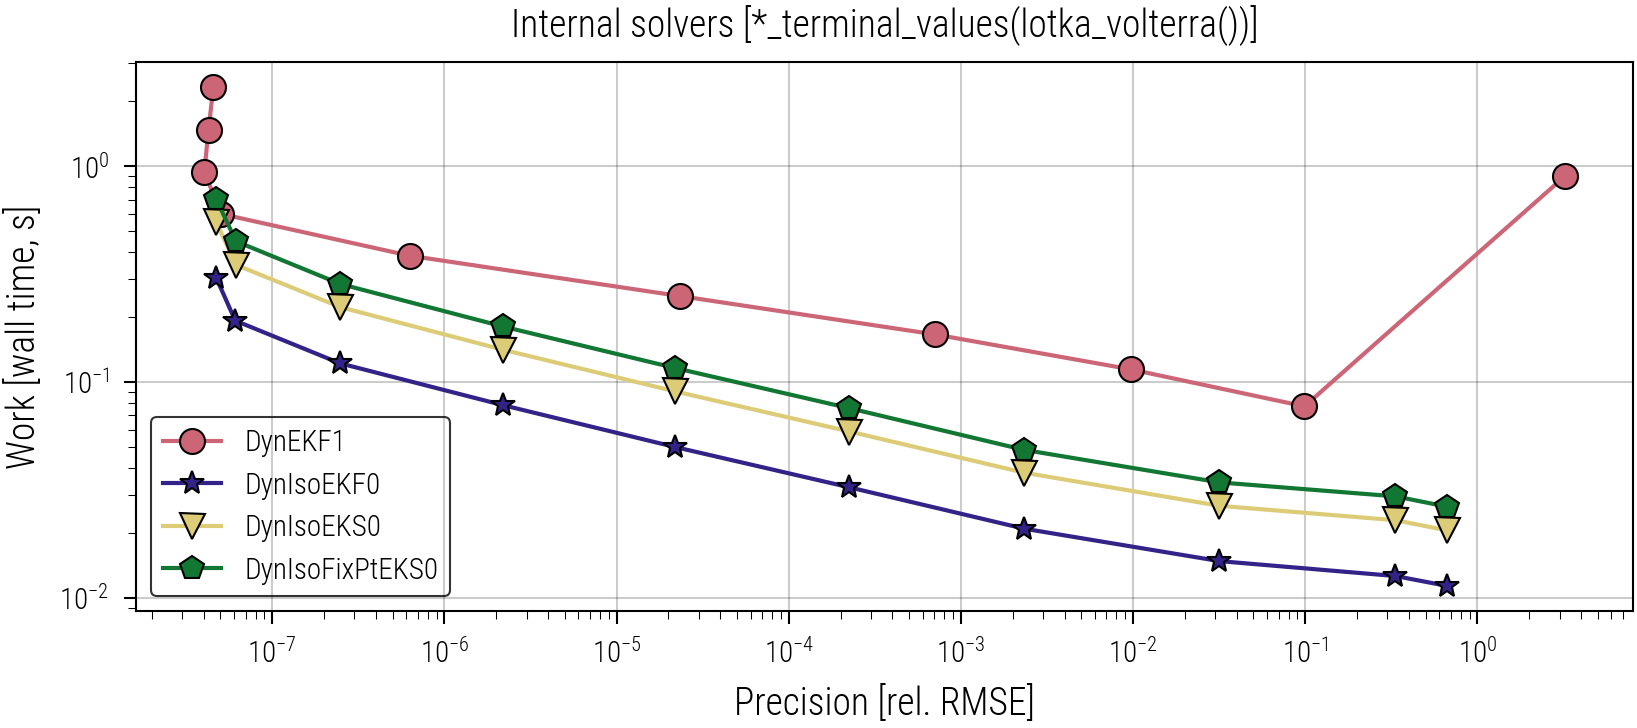

In [10]:
fig, ax = plt.subplots(dpi=300)

for solver in results:
    times, errors = results[solver]
    ax.loglog(errors, times, label=solver)

ax.grid("both")
ax.set_title("Internal solvers [*_terminal_values(lotka_volterra())]")
ax.set_xlabel("Precision [rel. RMSE]")
ax.set_ylabel("Work [wall time, s]")
ax.legend()
plt.show()

If these results show one thing, then the fact that it is worth building a specialised ODE solver
for simulate_terminal_values(). The smoothing-based solvers compute extra factors that are just not needed and quite expensive.

It also shows that the extra-work by the EK1, introduced by the need for Jacobians and the lack of a state-space model factorisation, makes the solver strictly more expensive than the isotropic EK0, even on a 4-dimensional problem.


## External solvers
TBD.